# Classez des images à l'aide d'algorithmes de Deep Learning

Nous souhaitons obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

Nous importons à notre habitude les librairies nécessaire.

In [55]:
from keras.utils import load_img, img_to_array
import shutil
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
import keras
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from keras.applications.xception import preprocess_input, decode_predictions
from keras import optimizers
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
from skimage import exposure
from skimage.restoration import denoise_wavelet

%matplotlib inline

Nous allons maintenant séparer les images dans des dossiers différents pour restructurer la disposition des données et les séparer dans un dossier de train utile à l'entraînement, un dossier de validation et un dossier final de test. Nous en profiterons également pour créer deux fonctions utiles à la visualisation de la courbe d'apprentissage et de validation du modèle ainsi que la courbe de perte en apprentissage et en validation du même modèle.

In [56]:
images_dir = 'data/'

def prepare_image():
    directory = os.listdir(images_dir)
    os.mkdir(f"data/train")
    os.mkdir(f"data/test")
    os.mkdir(f"data/validation")

    for dir in directory:
        dir_path = f"data/{dir}/"
        files = os.listdir(dir_path)
        if len(files) > 0:
            train_files = files[0:120]
            validation_files = files[121:171]
            test_files = files[172:194]

            os.mkdir(f"data/train/{dir}")
            os.mkdir(f"data/validation/{dir}")
            os.mkdir(f"data/test/{dir}")

            for f in train_files:
                shutil.copy(f"data/{dir}/{f}", f"data/train/{dir}/{f}")
            for f in validation_files:
                shutil.copy(f"data/{dir}/{f}", f"data/validation/{dir}/{f}")
            for f in test_files:
                shutil.copy(f"data/{dir}/{f}", f"data/test/{dir}/{f}")

            shutil.rmtree(f"data/{dir}")



def simple_plot_model(history_model):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def pretrained_plot_model(history_model):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(history_model.history['accuracy'])
    plt.plot(history_model.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(212)
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    plt.tight_layout()

    plt.show()

#prepare_image()

On spécifie désormais les chemins vers nos données respectives.

In [57]:
train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

Puisque nous travaillons sur un problème de classification d'image, les réseaux à convolution semblent parfaits face à cette problématique.

Nous tenterons dans un premier temps à faire notre propre réseau de Convolution en utilisant keras.

# CNN

In [58]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=120,
                                              target_size=(150, 150),
                                              class_mode='categorical')

validation_generator = datagen.flow_from_directory(validation_dir,
                                                   batch_size=50,
                                                   target_size=(150, 150),
                                                   class_mode='categorical')


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(120, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps = 50)

Found 14400 images belonging to 120 classes.
Found 4883 images belonging to 120 classes.
Epoch 1/30
100/100 [==============================] - 83s 827ms/step - loss: 4.7792 - acc: 0.0104 - val_loss: 4.7474 - val_acc: 0.0140
Epoch 2/30
100/100 [==============================] - 82s 824ms/step - loss: 4.6337 - acc: 0.0284 - val_loss: 4.5537 - val_acc: 0.0272
Epoch 3/30
100/100 [==============================] - 84s 841ms/step - loss: 4.4211 - acc: 0.0468 - val_loss: 4.3976 - val_acc: 0.0428
Epoch 4/30
100/100 [==============================] - 84s 840ms/step - loss: 4.2925 - acc: 0.0607 - val_loss: 4.3281 - val_acc: 0.0476
Epoch 5/30
100/100 [==============================] - 81s 814ms/step - loss: 4.1798 - acc: 0.0816 - val_loss: 4.2936 - val_acc: 0.0680
Epoch 6/30
100/100 [==============================] - 82s 821ms/step - loss: 4.0643 - acc: 0.0975 - val_loss: 4.2365 - val_acc: 0.0640
Epoch 7/30
100/100 [==============================] - 83s 834ms/step - loss: 3.9671 - acc: 0.1094 - v

In [59]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical')

model.evaluate(test_generator)

Found 758 images belonging to 120 classes.
76/76 [==============================] - 2s 22ms/step - loss: 9.1795 - acc: 0.0884


[9.179466247558594, 0.08839049935340881]

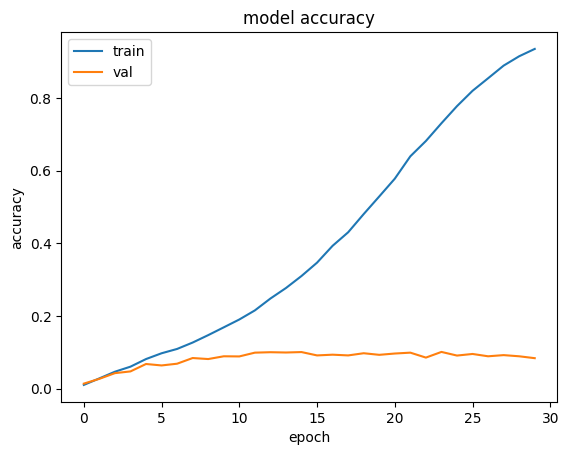

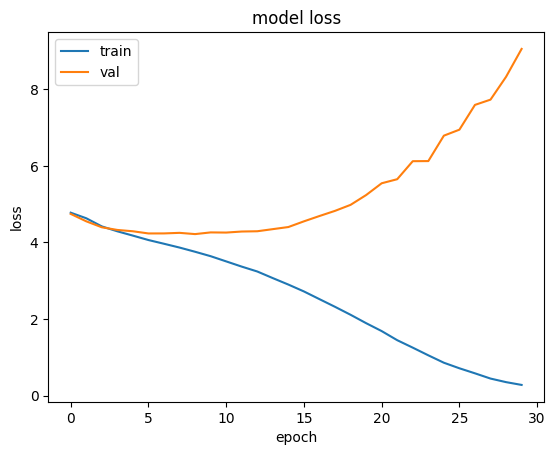

In [60]:
simple_plot_model(history)

Nous pouvons observer des résultats bien en dessous de ce que nous aurions pu espérer.

De plus au vu de la courbe d'apprentissage par rapport à celle de validation, nous voyons clairement que le modèle est en overfit.

En effet, il n'a pas assez de données et se spécialise sur les données qu'il possède. Ainsi il n'est plus en mesure de prédire avec précision de nouvelle image;

# OverFit & Data Augmentation

Nous allons donc utiliser une technique de data augmentation, en effet la data augmentation permet de créer de nouvelles données à partir des données d'origine en utilisant des techniques telles que la rotation, la translation, le zoom, la réflexion, etc., afin d'améliorer la performance du modèle de machine learning et de réduire l'OverFitting. 

On va également convertir notre image en objet PIl.Image, pour égaliser l'imge et faire un process de deblur qui permettra d'étaler de manière uniforme la répartition des niveaux de luminosité de l'image et à réduire le bruit présent dans une image. 

In [61]:
def preprocess_input_own(image):
    # Conversion de l'image en tenseur numpy si elle est sous forme d'objet PIL.Image
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Egalisation de l'histogramme
    image = exposure.equalize_hist(image)
    
    # Deblur de l'image
    image = denoise_wavelet(image)
    
    # Normalisation de l'image
    image = image / 255.
    image = image - 0.5
    image = image * 2.
    
    return image

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, preprocessing_function=preprocess_input_own)

In [62]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 14400 images belonging to 120 classes.
Found 4883 images belonging to 120 classes.


In [63]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(120, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

C:\Users\elect\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


Epoch 1/30
  9/100 [=>............................] - ETA: 31s - loss: 4.7876 - acc: 0.0000e+00

C:\Users\elect\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\elect\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


100/100 [==============================] - 37s 363ms/step - loss: nan - acc: 0.0075 - val_loss: nan - val_acc: 0.0081
Epoch 2/30
100/100 [==============================] - 36s 361ms/step - loss: nan - acc: 0.0078 - val_loss: nan - val_acc: 0.0088
Epoch 3/30
100/100 [==============================] - 36s 359ms/step - loss: nan - acc: 0.0100 - val_loss: nan - val_acc: 0.0088
Epoch 4/30
100/100 [==============================] - 36s 360ms/step - loss: nan - acc: 0.0088 - val_loss: nan - val_acc: 0.0050
Epoch 5/30
100/100 [==============================] - 36s 361ms/step - loss: nan - acc: 0.0091 - val_loss: nan - val_acc: 0.0069
Epoch 6/30
100/100 [==============================] - 36s 360ms/step - loss: nan - acc: 0.0100 - val_loss: nan - val_acc: 0.0050
Epoch 7/30
100/100 [==============================] - 36s 361ms/step - loss: nan - acc: 0.0072 - val_loss: nan - val_acc: 0.0050
Epoch 8/30
100/100 [==============================] - 36s 359ms/step - loss: nan - acc: 0.0091 - val_loss: n

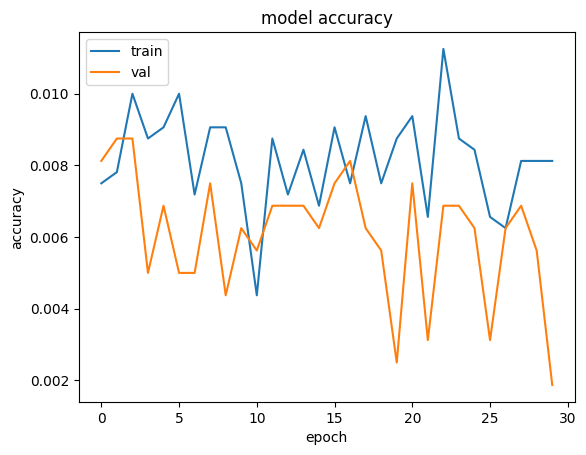

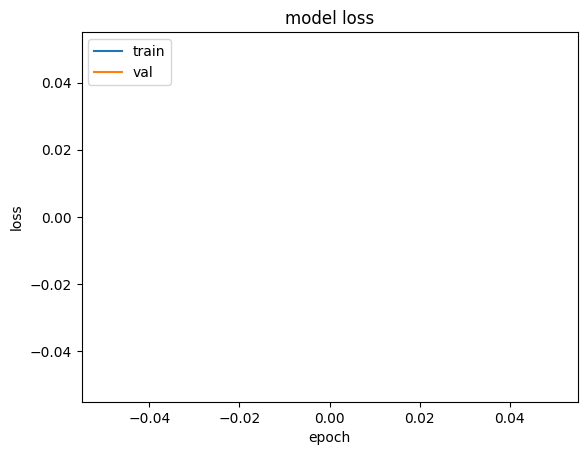

In [64]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)


simple_plot_model(history)

In [65]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical')

model.evaluate(test_generator)

Found 758 images belonging to 120 classes.
76/76 [==============================] - 2s 20ms/step - loss: nan - acc: 0.0000e+00


[nan, 0.0]

Nous pouvons voir que le modèle n'overffit plus mais que ses performances sont toujours bien en dessous de nos espérance.

Penchons nous donc sur des modèles pré-entrainée en essayant de les ajuster à notre problématique. (TransferLearning)

# VGG16

In [72]:
from keras.applications.xception import preprocess_input
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [73]:
num_classes = 120
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=20,
                                   horizontal_flip=True, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=32,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(validation_dir,
                                                target_size=(224,224),
                                                shuffle=False,
                                                batch_size=32,
                                                class_mode='categorical')

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

epochs = 100

history = model.fit(
    train_generator,
    steps_per_epoch = 120 // 32,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps = 50 // 32)

Found 14400 images belonging to 120 classes.
Found 4883 images belonging to 120 classes.
Epoch 1/100
3/3 [==============================] - 8s 2s/step - loss: 7.4046 - accuracy: 0.0000e+00 - val_loss: 24.8858 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 7s 2s/step - loss: 8.2780 - accuracy: 0.0000e+00 - val_loss: 14.6176 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 6s 2s/step - loss: 8.0643 - accuracy: 0.0208 - val_loss: 18.0453 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 6s 2s/step - loss: 8.1020 - accuracy: 0.0208 - val_loss: 17.7761 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 6s 2s/step - loss: 7.7222 - accuracy: 0.0208 - val_loss: 16.8285 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 6s 2s/step - loss: 7.5847 - accuracy: 0.0208 - val_loss: 19.2905 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [============================

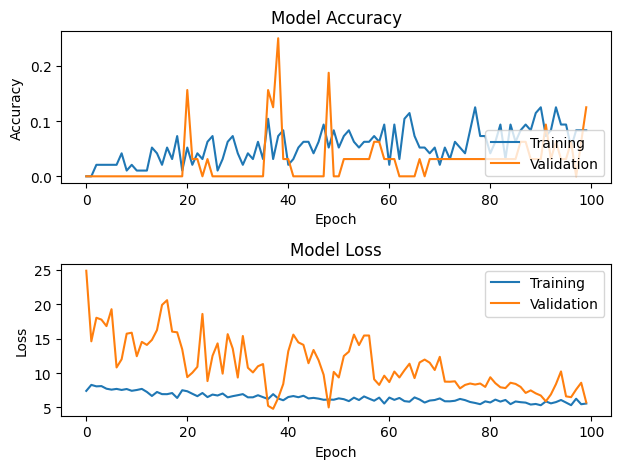

In [74]:
pretrained_plot_model(history)

In [75]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

results = model.evaluate(test_generator)
print(f"test loss, test acc: {results}")

Found 758 images belonging to 120 classes.
24/24 [==============================] - 29s 1s/step - loss: 430.2104 - accuracy: 0.0224
test loss, test acc: [430.21044921875, 0.02242744155228138]


On voit que le modèle VGG16 n'offre toujours pas les performances attendu malgrès l'usage de transferlearning & data augmentation notre IA ne semble toujours pas être très précise.

Essayons un autre modèle :

# Xception

In [76]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model = Xception(include_top=False,
                      input_shape = (299,299,3),
                      weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [77]:
num_classes = 120
x = keras.layers.BatchNormalization()(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=20,
                                   horizontal_flip=True, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(299,299),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(validation_dir,
                                                target_size=(299,299),
                                                shuffle=False,
                                                batch_size=batch_size,
                                                class_mode='categorical')

model.compile(loss="categorical_crossentropy",
              optimizer='rmsprop',
              metrics=["accuracy"])

epochs = 100

history = model.fit(
    train_generator,
    steps_per_epoch = 120 // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps = 50 // batch_size)

Found 14400 images belonging to 120 classes.
Found 4883 images belonging to 120 classes.
Epoch 1/100
3/3 [==============================] - 8s 2s/step - loss: 4.9999 - accuracy: 0.0521 - val_loss: 4.5896 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 6s 2s/step - loss: 4.4253 - accuracy: 0.1458 - val_loss: 4.6259 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 6s 2s/step - loss: 3.8460 - accuracy: 0.2292 - val_loss: 4.6802 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 6s 2s/step - loss: 3.4818 - accuracy: 0.2292 - val_loss: 4.1184 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 6s 2s/step - loss: 3.1166 - accuracy: 0.3125 - val_loss: 4.2685 - val_accuracy: 0.0312
Epoch 6/100
3/3 [==============================] - 6s 2s/step - loss: 2.9368 - accuracy: 0.3542 - val_loss: 3.5459 - val_accuracy: 0.4375
Epoch 7/100
3/3 [==============================] - 6s 2s/step - los

In [78]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

results = model.evaluate(test_generator)
print(f"test loss, test acc: {results}")

Found 758 images belonging to 120 classes.
24/24 [==============================] - 18s 730ms/step - loss: 150.9289 - accuracy: 0.0053
test loss, test acc: [150.9289093017578, 0.0052770450711250305]


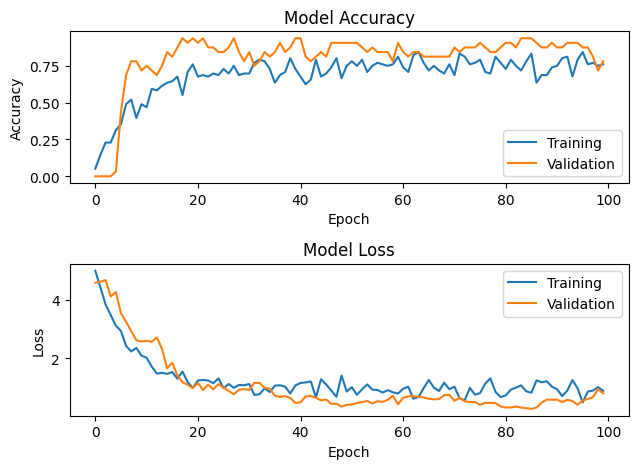

In [79]:
pretrained_plot_model(history)

On voit ici que le modèle apprend plutôt bien et que les images de validation semblent être plutôt bien interprétées.

Nous avons un bon score d'accuracy dépassant les 80%.

Nous allons enregistrer le modèle et essayer de l'utiliser pour prédire de nouvelles images

In [80]:
model.save('model_final_save.h5')

# Prédiction

1/1 [==============================] - 1s 518ms/step
Label prédit: n02099601-golden_retriever


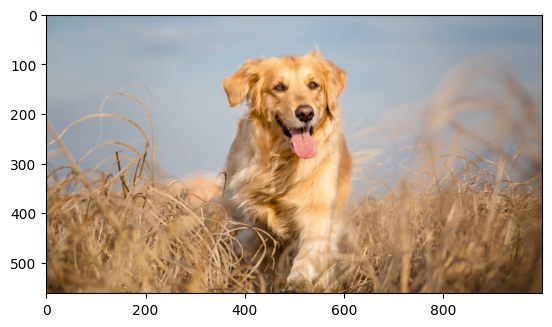

In [81]:
test_image = 'data/prediction/prediction.jpg'
img = load_img(test_image)
plt.imshow(img)
img_tensor = np.array(img.resize((299, 299)))
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

def predict(model, img, class_names):
    preds = model.predict(img_tensor)
    pred_label =  class_names[np.argmax(preds)]
    return pred_label

prediction = predict(model, img_tensor, class_names=os.listdir("data/train"))

print(f"Label prédit: {prediction}")

Notre modèle prédit la bonne race : Il s'agit bel et bien d'un golden retriever.